In [1]:
from fastai import *
from fastai.text import *
import os
import pathlib as path
import pandas as pd
import re
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

### Constants
Missing parts, look nb converts!!!

In [2]:
HOME = path.Path('/home/jovyan/work')
DATA = HOME/'data'
bs=128
DOWNLOAD_LINK=""

In [3]:
CORPUS = DATA/'corpus'
MODELS = CORPUS/'models'
# already done !$HOME/wikicorpus.py $DATA/hrwiki_data.xml.bz2 $CORPUS

In [4]:
df = pd.read_csv(DATA/'twitter.csv', engine='python')
df.head()

,Text,HandLabel
0,SEO Optimizacija web stranica,Positive
1,@h1telekom hehehehe dogovoreno :),Positive
2,MISAO IZ EVANĐELJA DANA\nČuvajte se kvasca far...,Neutral
3,Karen O i Spike Jonze zajedno izveli 'The Moon...,Positive
4,@Clouseaui daleko je@mikica0806,Negative


In [24]:
# Clean and preprocess text for sentiment analysis
def clean_text(df):
  text = df['text']
  text = re.sub(r'http\S+','', str(text))
  punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
  text = ''.join(ch for ch in text if ch not in set(punctuation))
  text = text.lower()
  #remove numbers
  text = text.replace("[0-9]", " ")
  # Remove whitespaces
  text = ' '.join(text.split())
  return text

# Convert text labels to numbers
def label_to_nr(df):
    """Convert label to number index (string)"""
    label = str(df['label']).strip().lower()
    if label in ('0','1','2'):
        return label
    elif label in ('none',''): #No label, neutral
        return str(1)
    elif "positive" in label:
        return str(2)
    elif "negative" in label:
        return str(0)
    else: #eg NaN, null
        return str(1)

In [25]:
df.columns = ["text", "label"] 
df["text"] = df.apply(clean_text, axis=1)
df["label"] = df.apply(label_to_nr, axis=1)
df.head()

,text,label
0,seo optimizacija web stranica,2
1,h1telekom hehehehe dogovoreno,2
2,misao iz evanđelja dana čuvajte se kvasca fari...,1
3,karen o i spike jonze zajedno izveli 'the moon...,2
4,clouseaui daleko jemikica0806,0


In [7]:
data_twitter_lm = (TextList.from_df(df, DATA)
                .split_by_rand_pct(0.1)
                .label_for_lm()   
                .databunch(bs=bs))
data_twitter_lm.save('tmp2_lm')

In [23]:
data_twitter_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',']

In [35]:
data_twitter_lm.vocab.save(MODELS/'twitter_vocab.pkl')

In [8]:
data_lm = load_data(DATA, 'tmp2_lm', bs=bs)
data_lm.show_batch()

idx,text
0,"i m a nade za tebe , jer i kruh se xxunk xxbos moderna borba protiv xxunk . tko i m a bolji xxunk xxbos započelo treće zasjedanje pape franje s xxunk kardinala xxbos 18 diy projekata koji će vam promijeniti pakiranje zauvijek xxbos počinju tečajevi male škole u xxunk xxbos rt marijazg rockmarkzg sretan rođendan xxbos internet trgovine zatvaraju vrata malih lokalnih dućana xxbos 25 xxunk s kojima ćete"
1,"pranje novca neke su od tema xxbos premijera telefonske xxunk opere la xxunk xxunk u xxunk it d xxunk xxunk xxunk xxbos za poduzetnički impuls ove godine xxunk milijardi kuna xxbos video nećete vjerovati što su napravili čakovčani ova se snimka munjevito širi internetom xxbos istina za drugo “ xxunk maratonka mi smo u planu 21 , ne i u 21 . stoljeću . ” xxbos sve veličine su lijepe"
2,"odbijenicu na registraciju valjda . ok , hvala na info xxbos papa franjo s xxunk kardinala xxunk o xxunk banci xxbos dpozaric kjukar sasabca za soma kuna dobijes cb xxunk sa jos 2 xxunk za xxunk stranica i ne xxunk se da ce ti se xxunk glava xxbos molfiks riješeno . sve imam xxbos rt ninabadric7 hayatproduction sarajevo ljubav zetra 14.02.2013 . hayatproduction hvala vam na na podrsci , vjeri"
3,"često puca iako pokazuje cont xxbos sweet zazoo lt3 xxbos jovanović ministri će pristati na bilo kakvo smanjenje plaća xxbos jeste li već bili kod nas u kući europe niste dođite i pitajte nas što vas zanima , čekamo vas xxbos pročitajte recenziju portala soundguardian live albuma majki majke u tvornici xxbos je li svjedok obrane sudjelovao u xxunk via rsebalkan xxbos popodnevni mrdoguz xxunk xxunk xxbos xxunk sretno xxbos"
4,"i zagrebdox xxbos iznenađenje xxunk queens of the stone age 11 . 6 . u srbiji xxbos doista je tako jednostavno ... xxbos facebook kupuje whatsapp za 19 milijardi dolara prvasmjena xxbos 2cellos luka xxunk i stjepan hauser obradili su pjesmu thunderstruck grupe acdc , za koju su snimili i spot xxbos djgigo ma jucer sam cuo gluposti koje je prije jos xxunk . na radiju su ga malo xxunk"


In [9]:
FILE_LM_ENCODER = MODELS/'pretrained_model'
FILE_ITOS = MODELS/'pretrained_itos'
learn = language_model_learner(data_lm,  AWD_LSTM, pretrained=True, pretrained_fnames=[FILE_LM_ENCODER, FILE_ITOS], drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


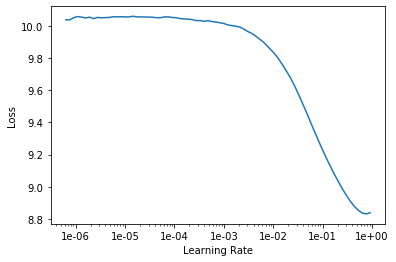

In [10]:
learn.lr_find()
learn.recorder.plot(skip_end=12)

In [11]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.834533,5.924828,0.183787,00:16


In [12]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.972684,5.666952,0.202983,00:19
1,5.729928,5.399590,0.225913,00:19
2,5.439804,5.141660,0.252912,00:20
3,5.231522,5.016256,0.265757,00:20
4,4.914305,4.855427,0.284274,00:19
5,4.677312,4.761786,0.295647,00:19
6,4.481447,4.709623,0.302780,00:20
7,4.342571,4.682114,0.307823,00:20
8,4.258834,4.674148,0.308969,00:19
9,4.210370,4.672583,0.309132,00:19


In [16]:
learn.predict('Sviđa mi se zbog ',  temperature=1.1, min_p=0.001, n_words=10)

'Sviđa mi se zbog  ovog tiska ne zna . xxbos rt tportal važno stožer'

In [17]:
learn.save_encoder(MODELS/'fine_tuned_enc')

In [29]:
data_clas = (TextList.from_df(df, DATA, vocab=data_lm.vocab)
                .split_by_rand_pct(0.1) 
                .label_from_df(cols=1)
                 #remove docs with labels not in above list (i.e. ' ')
                 .databunch(bs=bs))
data_clas.save('tmp_clas')

In [31]:
data_clas = load_data(DATA, 'tmp_clas', bs=bs)
data_clas.show_batch()

text,target
xxbos slatka 3 lt3lt3lt3 — hvala 3 ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤,2
xxbos sabina15 dina je najbolja osoba koju znam volim te najvise xxunk moja savrsena bas si prezgodna xxrep 7 😍 xxrep 5 👌 ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️ ❤ ️,2
xxbos petarvevo a zato kaj su bili jadni . sjeti se da je i tada bila velika kriza . od xxunk vise nisu znali sta bi pa i m je i taj plan bio wow .,0
"xxbos dobro jutro dragi naši tko nema u glavi i m a u nogama , tko nema u nogama i m a u banci , tko nema u banci i m a nešto ...",1
"xxbos kresoz ma sama liga je ok , kao i kvaliteta , samo su mi te umjetno stvorene lige i natjecanja aba , seha , ebel , khl , i sl skroz xxunk ...",2


In [34]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder(MODELS/'fine_tuned_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


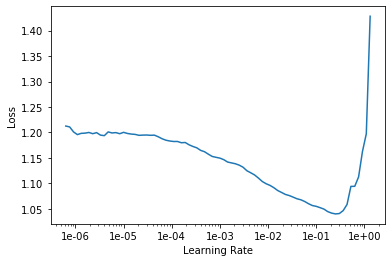

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.877639,0.823120,0.612927,00:08


In [37]:
learn.save(MODELS/'first-clas')

In [39]:
learn.load(MODELS/'first-clas');

In [40]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.828886,0.791410,0.631373,00:09


In [41]:
learn.save(MODELS/'second-clas')

In [42]:
learn.load(MODELS/'second-clas');

In [43]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.806354,0.768187,0.638780,00:14


In [46]:
learn.save(MODELS/'third-clas')

In [47]:
learn.load(MODELS/'third-clas')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (61969 items)
x: TextList
xxbos seo optimizacija web stranica,xxbos xxunk hehehehe dogovoreno,xxbos misao iz evanđelja dana čuvajte se kvasca xxunk i kvasca xxunk . utorak , 18 . 2 . 2014 . svagdan čitanja ...,xxbos karen o i spike jonze zajedno izveli ' the moon song ',xxbos clouseaui daleko xxunk
y: CategoryList
2,2,1,2,0
Path: /home/jovyan/work/data;

Valid: LabelList (6885 items)
x: TextList
xxbos angiezg xxunk jos jedan ovdje jer ne da dva,xxbos još mjesec i tjedan dana , a onda .. harley xxunk days tri dana raja . ca n't wait,xxbos rt khlmedvescakzg danas u brlogu 4 . utakmica khlplayoffs lev vodi u seriji 30 . nijedna khl momčad nije okrenula 30 seriju , mogu li …,xxbos xxunk francis nikada nece biti papa franjo .,xxbos za fanove serije truedetective jedna playlista s pjesmama iz prve sezone gt
y: CategoryList
1,2,1,1,1
Path: /home/jovyan/work/data;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_

In [48]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.778761,0.763351,0.642847,00:18
1,0.761608,0.759304,0.647204,00:18


In [49]:
learn.save(MODELS/'final-clas')

In [66]:
learn.predict("Osjećam se fenomenalno dobro")

(Category 2, tensor(2), tensor([0.1780, 0.1966, 0.6254]))

In [68]:
learn.export()

In [69]:
doc(load_learner)

load_learner [source] [test] load_learner ( path : PathOrStr , file : PathLikeOrBinaryStream = 'export.pkl' , test : ItemList = None , tfm_y = None , ** db_kwargs ) 
 
 × Tests found for load_learner : pytest -sv tests/test_basic_train.py::test_export_load_learner [source] To run tests please refer to this guide . Load a Learner object saved with export_state in path/file with empty data, optionally add test and load on cpu . file can be file-like (file or buffer) 
 Show in docs